# Notebook EDA del Titanic con datos de Kaggle

# Celda 1 — Imports y ajustes:
Configuración inicial: Imports y ajustes
Utilidades (guardar imágenes/tablas; no toca README)

In [1]:
# Celda 1 — Imports y ajustes:
# Utilidades (guardar imágenes/tablas; no toca README)
# Importar librerías necesarias

%matplotlib inline

from pathlib import Path                 # Manejo de rutas y carpetas
import matplotlib.pyplot as plt          # Gráficos base (Matplotlib)
import pandas as pd                      # DataFrames
import numpy as np                       # Cálculo numérico (percentiles, etc.)
import warnings; warnings.filterwarnings("ignore")
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.impute import SimpleImputer
sns.set_theme()

# Se guardan los PNG generados de gráficos y tablas en la carpeta figures/
# Las imágenes se sobrescriben de una ejecución a otra
# Las imágenes las podremos presentar en el propio README.md llamando desde el mismo a la referencia al figures/<name>.png

FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


def savefig(name, dpi=150, tight=True):
    """Guarda la figura actual en figures/<name>.png (sobrescribe)."""
    out = FIG_DIR / f"{name}.png"
    if tight:
        plt.savefig(out, dpi=dpi, bbox_inches='tight')
    else:
        plt.savefig(out, dpi=dpi)
    print('Guardado:', out)

def save_table_image(df_or_series, name: str, title: str | None = None,
                     fontsize: int = 10, col_width: float = 2.2,
                     row_height: float = 0.6, max_rows: int | None = 30,
                     round_ndigits: int | None = 2):
    """Renderiza un DataFrame/Series como PNG en figures/<name>.png (sobrescribe)."""
    if isinstance(df_or_series, pd.Series):
        df = df_or_series.to_frame()
    else:
        df = df_or_series.copy()
    if round_ndigits is not None:
        for c in df.select_dtypes(include=[np.number]).columns:
            df[c] = df[c].round(round_ndigits)
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)
    overflow_note = ''
    if max_rows is not None and len(df) > max_rows:
        df = df.iloc[:max_rows, :]
        overflow_note = f' (truncado a {max_rows} filas)'
    n_rows, n_cols = df.shape
    fig_w = max(6, col_width * (n_cols + 1))
    fig_h = max(2.5, row_height * (n_rows + 2))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis('off')
    if title:
        ax.set_title(title + overflow_note, fontsize=fontsize+2, pad=10)
    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.scale(1.0, 1.2)
    out_path = FIG_DIR / f"{name}.png"
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    plt.close(fig)
    print('Tabla guardada:', out_path)

# FASE 1 Exploración incial: Reconocimiento del Dataset
Carga 891 pasajeros, 15 características
Identifica tipos: numéricos vs categóricos vs texto

## Celda 2 — cargar Kaggle CSV (normalizamos nombres)

**Estructura del dataset:**

Conocer la estructura del conjunto de datos, los tipos de variables y obtener un primer vistazo de estos, es esencial para identificar posibles problemas y tomar decisiones informadas sobre cómo proceder con el análisis. 

La estructura del dataset se refiere a cómo están organizados los datos y su formato general. Al comprender la estructura, podemos saber qué esperar de ellos y cómo acceder a la información necesaria.

**- Filas y columnas:** Es importante verificar cuántas filas (registros) y columnas (características) contiene el conjunto de datos. Esto se puede hacer con la función df.shape en Pandas.
**- Nombres de las columnas:** Identificar los nombres de las columnas es clave para saber qué variables se están analizando. Se puede visualizar con df.columns.
**- Tamaño y dimensiones:** Si los datos son grandes, es útil comprobar las primeras filas o una muestra aleatoria para conocer la "dimensión" de los datos sin sobrecargar la memoria. Se puede usar df.head() o df.sample().
**- Tipo de archivo:** El dataset puede estar en varios formatos, como CSV, Excel, JSON, SQL, etc. Es importante saber cómo leerlo y cargarlo correctamente dependiendo de su formato.

**Tipos de Datos o variabes:**

**- Datos Numéricos:**			(datos que podemos medir)
 **•	Continuos:** Pueden tomar cualquier valor en un rango (altura, peso, temperatura)
 **•	Discretos:** Valores enteros específicos (número de hijos, cantidad de productos)

**Tratamiento en EDA:**
•	Estadísticas descriptivas (media, mediana, desviación estándar)
•	Histogramas, boxplots, gráficos de densidad
•	Análisis de distribución y detección de outliers


**- Datos Categóricos:	(datos con etiquetas, clasificación)
  **•	Nominales:** Sin orden inherente (color, género, país)
  **•	Ordinales:** Con orden específico o lógico (educación: primaria < secundaria < universitaria)

**Tratamiento en EDA:**
•	Tablas de frecuencia y porcentajes
•	Gráficos de barras, pie charts
•	Análisis de moda y distribución de categorías

**- Datos Temporales:**
  **•	Fechas, timestamps, series de tiempo**

Tratamiento en EDA:
•	Análisis de tendencias temporales
•	Estacionalidad y patrones cíclicos
•	Gráficos de líneas temporales

Consideraciones especiales del tratamiento de datos en EDA:
**•	Datos categóricos:** Sólo se puede calcular la moda como medida de tendencia central
**•	Datos ordinales:** Permiten cálculos de mediana y percentiles, pero no operaciones aritméticas complejas
**•	Datos numéricos:** Permiten todas las operaciones estadísticas y visualizaciones



**Primer Vistazo a los Datos**

Un primer vistazo a los datos nos permite verificar la calidad de la información y detectar posibles problemas. Aquí algunos pasos iniciales a realizar:

**•	Revisión de las primeras filas:** Obtener un resumen rápido de los primeros registros del dataset usando **df.head()**. Esto muestra las primeras filas y ayuda a detectar posibles problemas como datos mal ingresados.


In [2]:
# === Celda 2: Carga Kaggle, normaliza nombres y guarda tablas/imágenes al README ===

# Celda 2 — Carga de datos desde Kaggle y normalización
train = pd.read_csv("data/train.csv")

cols_map = {
    "Survived": "survived",
    "Pclass":   "pclass",
    "Sex":      "sex",
    "Age":      "age",
    "SibSp":    "sibsp",
    "Parch":    "parch",
    "Fare":     "fare",
    "Embarked": "embarked",
}
existing = [c for c in cols_map if c in train.columns]
df = train[existing].rename(columns=cols_map)

# Tipos recomendados
if "survived" in df.columns: df["survived"] = df["survived"].astype(int)
if "sex" in df.columns: df["sex"] = df["sex"].astype("category")
if "embarked" in df.columns: df["embarked"] = df["embarked"].astype("category")

# Primeras filas del dataset
display(df.head()); print("Shape:", df.shape); print(df.dtypes)

# Guardar imágenes de tablas
save_table_image(df.head(), "tbl_head_raw", title="Head (raw normalizado)", round_ndigits=None)
dtypes_tbl = df.dtypes.astype(str).to_frame("dtype")
save_table_image(dtypes_tbl, "tbl_dtypes", title="Tipos de datos", round_ndigits=None)
shape_tbl = pd.DataFrame({"value":[df.shape[0], df.shape[1]]}, index=["rows","cols"])
save_table_image(shape_tbl, "tbl_shape", title="Shape del DataFrame", round_ndigits=None)


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Shape: (891, 8)
survived       int64
pclass         int64
sex         category
age          float64
sibsp          int64
parch          int64
fare         float64
embarked    category
dtype: object
Tabla guardada: figures\tbl_head_raw.png
Tabla guardada: figures\tbl_dtypes.png
Tabla guardada: figures\tbl_shape.png


# FASE 2 Evaluación de la calidad:
Detecta: age (177 nulos), cabin (687 nulos), embarked (2 nulos) Estadísticas: 38% supervivencia, edades 0.42-80 años, tarifas 0-512£


# Celda 3 — Inspección y diagnóstico

**•	Revisión de tipos de datos:** Verificar que los tipos de datos de cada columna sean correctos (por ejemplo, asegurarse de que las fechas estén en formato de fecha). Se puede hacer con **df.dtypes**.
**•	Valores faltantes o nulos:** Identificar columnas con valores faltantes usando **df.isnull().sum()**, **df.isna().sum()**. Esto puede ayudar a identificar si es necesario imputar o eliminar datos.
**•	Estadísticas descriptivas básicas:** Obtener un resumen de las estadísticas básicas (media, mediana, desviación estándar, etc.) con **df.describe()**. Esto es útil para detectar anomalías o valores atípicos de forma temprana.


In [3]:
# === Celda 3: Inspección inicial + guardar tablas + actualizar README ===

# Información sobre tipos de datos y valores nulos por columna
nulls = df.isna().sum().sort_values(ascending=False)
display(nulls)
save_table_image(nulls, "tbl_nulls", title="Valores nulos por columna", round_ndigits=None)

# Estadísticas descriptivas básicas
desc_num = df.describe()
display(desc_num)
save_table_image(desc_num, "tbl_desc_num", title="Estadísticas (numéricas)")

# Verificar dimensiones del dataset
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

cat_cols = df.select_dtypes(include=["object","category"]).columns
if len(cat_cols):
    desc_cat = df[cat_cols].describe().T
    display(desc_cat)
    save_table_image(desc_cat, "tbl_desc_cat", title="Estadísticas (categóricas)", round_ndigits=None)

    cardinal = df[cat_cols].nunique().sort_values(ascending=False).to_frame("nunique")
    display(cardinal)
    save_table_image(cardinal, "tbl_cardinality", title="Cardinalidad de categóricas", round_ndigits=None)
else:
    print("(No hay columnas categóricas)")

age         177
embarked      2
pclass        0
survived      0
sex           0
sibsp         0
parch         0
fare          0
dtype: int64

Tabla guardada: figures\tbl_nulls.png


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Tabla guardada: figures\tbl_desc_num.png
El dataset tiene 891 filas y 8 columnas


,count,unique,top,freq
sex,891,2,male,577
embarked,889,3,S,644


Tabla guardada: figures\tbl_desc_cat.png


,nunique
embarked,3
sex,2


Tabla guardada: figures\tbl_cardinality.png


# FASE 3: Limpieza (Celda 4 a Celda 6)

# Celda 4 — limpieza (duplicados, imputación, feature)
Imputa age con mediana (más robusta que media) Imputa embarked con moda Crea family_size = siblings + parents + 1

In [4]:
# Celda 4 — Limpieza: duplicados, imputación, feature engineering

before = len(df)
df = df.drop_duplicates()
print("Duplicados eliminados:", before - len(df))

if "age" in df.columns:
    df["age"] = SimpleImputer(strategy="median").fit_transform(df[["age"]]).ravel()

if "embarked" in df.columns:
    df["embarked"] = df["embarked"].astype(object)
    df["embarked"] = SimpleImputer(strategy="most_frequent").fit_transform(df[["embarked"]]).ravel()
    df["embarked"] = df["embarked"].astype("category")

if {"sibsp","parch"}.issubset(df.columns):
    df[["sibsp","parch"]] = df[["sibsp","parch"]].fillna(0)
    df["sibsp"] = df["sibsp"].astype(int)
    df["parch"] = df["parch"].astype(int)
    df["family_size"] = df["sibsp"] + df["parch"] + 1

cols_verif = [c for c in ["age","embarked"] if c in df.columns]
nulls_post = df[cols_verif].isna().sum() if cols_verif else pd.Series(dtype="int64")
display(nulls_post)

save_table_image(df.head(), "tbl_head_post_clean", title="Head tras limpieza", round_ndigits=None)
if len(nulls_post):
    save_table_image(nulls_post, "tbl_nulls_post", title="Nulos tras imputación", round_ndigits=None)




Duplicados eliminados: 111


age         0
embarked    0
dtype: int64

Tabla guardada: figures\tbl_head_post_clean.png
Tabla guardada: figures\tbl_nulls_post.png


# Celda 5: Análisis Univariado (hist edad + conteos survived) 

**Análisis Univariado:**

El **análisis univariado** es el primer paso en la exploración de datos y se centra en examinar cada variable individualmente. Su objetivo es comprender la distribución, tendencia central y dispersión de los datos, además de identificar posibles valores atípicos.

**- Distribución de Variables Individuales:**

El análisis de la distribución de una variable ayuda a entender cómo se comportan los datos y si siguen una forma específica, como una distribución normal, uniforme o sesgada. Algunas técnicas clave incluyen:

**•	Histogramas:** Muestran la frecuencia de los valores en intervalos específicos, proporcionando una visión general de la forma de la distribución. Se pueden generar con **matplotlib.hist()** o **seaborn.histplot()**.

**•	Gráficos de densidad (KDE):** Una alternativa más suave a los histogramas que usa funciones de estimación de densidad de kernel para visualizar la distribución (**seaborn.kdeplot()**).

**•	Boxplots:** Ayudan a identificar la mediana, cuartiles y valores atípicos de la distribución de una variable (**seaborn.boxplot()**).

**- Medidas de Tendencia Central y Dispersión:**

Las estadísticas descriptivas permiten resumir los datos y entender su comportamiento general. Entre las más importantes están:

**- Medidas de tendencia central:**
        Media ((\mu)): Promedio de los valores de la variable.
        Mediana: Valor central cuando los datos están ordenados, útil para distribuciones sesgadas.
        Moda: Valor más frecuente en la distribución.

**- Medidas de dispersión:**
        Varianza ((\sigma^2)): Indica qué tan dispersos están los datos respecto a la media.
        Desviación estándar ((\sigma)): Raíz cuadrada de la varianza, mide la dispersión en las mismas unidades que los datos.
        Rango intercuartílico (IQR): Diferencia entre el tercer y el primer cuartil ((Q3 - Q1)), útil para detectar outliers.


**- Identificación de Outliers**

Los valores atípicos pueden distorsionar el análisis y afectar la precisión de los modelos. Algunas técnicas para detectarlos incluyen:

**•	Método del rango intercuartílico (IQR)**
        Se consideran outliers los valores que están por debajo de (Q1 - 1.5 \times IQR) o por encima de (Q3 + 1.5 \times IQR).
        Se pueden visualizar con boxplots.

**•	Z-score (puntaje Z)**
        Mide cuántas desviaciones estándar se aleja un dato de la media.
        Se usa el criterio de valores absolutos mayores a 3 para identificar outliers.

**•	Gráficos de dispersión (scatter plots)**
        Permiten observar puntos anómalos en distribuciones numéricas.



Guardado: figures\plot_hist_age.png


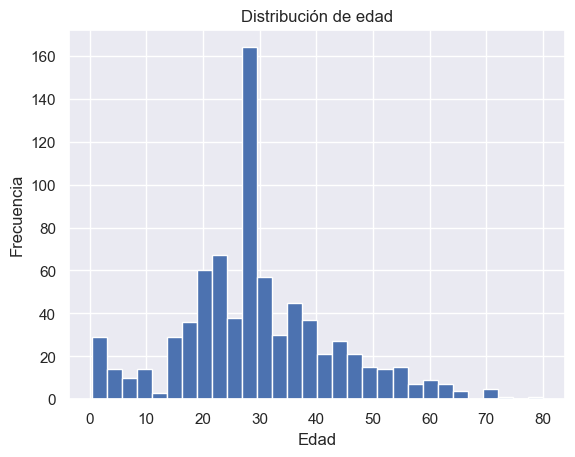

Guardado: figures\plot_count_survived.png


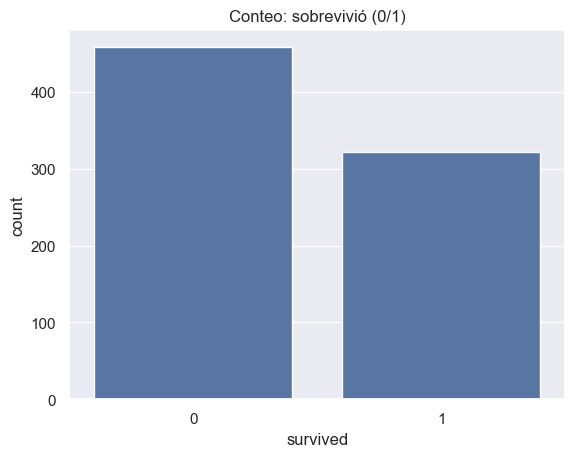

Tabla guardada: figures\tbl_survived_counts.png


In [5]:
# === Celda 5: Univariado (hist age + conteo survived) ==

imgs = []

if "age" in df.columns:
    plt.figure()
    df["age"].dropna().plot(kind="hist", bins=30)
    plt.title("Distribución de edad"); plt.xlabel("Edad"); plt.ylabel("Frecuencia")
    savefig("plot_hist_age")
    plt.show()

if "survived" in df.columns:
    plt.figure()
    sns.countplot(x="survived", data=df)
    plt.title("Conteo: sobrevivió (0/1)")
    savefig("plot_count_survived")
    plt.show()

    vc = df["survived"].value_counts().rename_axis("survived").to_frame("count")
    save_table_image(vc, "tbl_survived_counts", title="Conteo survived (0/1)", round_ndigits=None)




### plot_hist_age.png
```bash
**Qué es:** Histograma de distribución de edades
**Qué muestra:** Pico en 20-30 años, pocos niños y ancianos
**Insight:** Mayoría pasajeros eran jóvenes adultos
```

### plot_count_survived.png
```bash
**Qué es:** Gráfico de barras de supervivencia
**Qué muestra:** 549 muertos vs 342 vivos (38% supervivencia)
**Insight:** Mayoría de pasajeros murió en el desastre
```

# Celda 6: Análisis Bivariado

**Análisis Bivariado y Multivariado**

El **análisis bivariado y multivariado** se centra en estudiar las relaciones entre dos o más variables dentro de un conjunto de datos. Mientras que el análisis bivariado examina la relación entre dos variables, el análisis multivariado permite comprender interacciones más complejas entre múltiples variables.
5.1. Relaciones entre Variables

El primer paso en el análisis bivariado y multivariado es determinar si existe una relación entre las variables y qué tipo de relación presentan:

**•	Relaciones entre variables numéricas**
        Gráficos de dispersión (scatter plots): Útiles para visualizar relaciones lineales o no lineales.
        Diagramas de hexbin o pair plots con **seaborn.pairplot()** para detectar patrones.

**•	Relaciones entre una variable categórica y una numérica**
        Boxplots y violin plots: Comparan la distribución de una variable numérica dentro de diferentes categorías.
        Diagramas de barras (bar plots): Comparan promedios o medianas entre grupos.

**•	Relaciones entre variables categóricas**
        Tablas de contingencia y gráficos de barras apiladas para visualizar distribuciones conjuntas.


Guardado: figures\plot_box_fare_survived.png


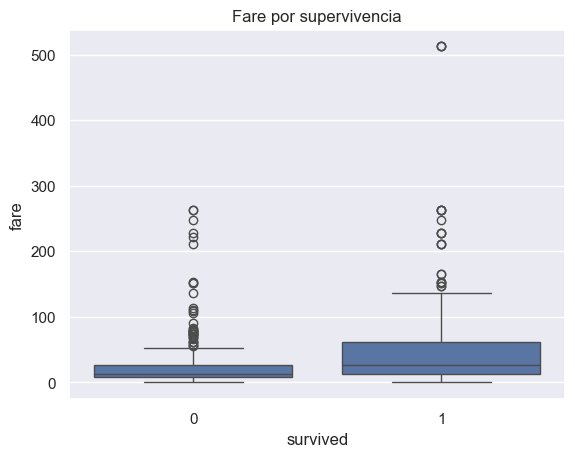

Guardado: figures\plot_count_sex_survived.png


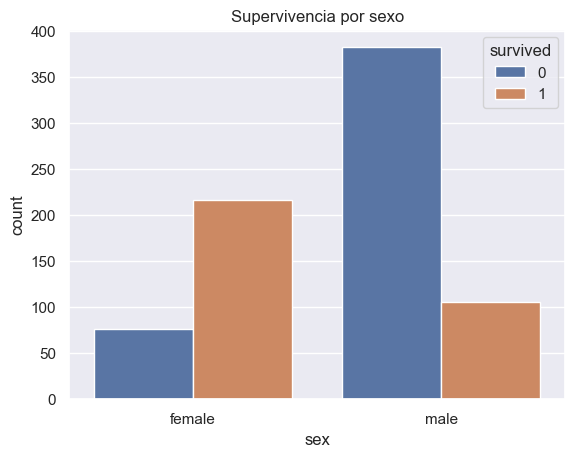

In [6]:
# === Celda 6: Bivariado (fare vs survived, sex vs survived) ===

if {"fare","survived"}.issubset(df.columns):
    plt.figure()
    sns.boxplot(x="survived", y="fare", data=df)
    plt.title("Fare por supervivencia")
    savefig("plot_box_fare_survived")
    plt.show()

if {"sex","survived"}.issubset(df.columns):
    plt.figure()
    sns.countplot(x="sex", hue="survived", data=df)
    plt.title("Supervivencia por sexo")
    savefig("plot_count_sex_survived")
    plt.show()




### plot_box_fare_survived.png
```bash
**Qué es:** Boxplot de tarifas por supervivencia
**Qué muestra:** Supervivientes pagaron tarifas MÁS ALTAS
**Insight:** La clase social influyó en supervivencia
```

### plot_count_sex_survived.png
```bash
**Qué es:** Barras agrupadas de sexo vs supervivencia
**Qué muestra:** Mayoría mujeres vivas, mayoría hombres muertos
**Insight:** "Mujeres y niños primero" se cumplió
```

# FASE 4 Análisis profundo. Outliers:

# Celda 7: Matriz de Correlación y outliers
Detecta usando método IQR Conserva outliers como legítimos (ancianos, primera clase)

**- Matrices de correlación**

La correlación mide la relación lineal entre dos variables numéricas y se expresa en valores entre -1 y 1:

    Coeficiente de correlación de Pearson:
        Evalúa la relación lineal entre dos variables continuas.
        Se calcula con df.corr(method='pearson') en pandas.

    Coeficiente de correlación de Spearman:
        Se usa para relaciones monótonas (no necesariamente lineales).
        Se calcula con df.corr(method='spearman').

    Mapa de calor de correlación
        Se utiliza seaborn.heatmap(df.corr(), annot=True, cmap='coolwarm') para visualizar correlaciones de múltiples variables.

**-	Comparación entre Grupos**

Cuando se trabaja con datos categóricos y numéricos, es importante comparar los diferentes grupos para identificar diferencias significativas:

    Pruebas estadísticas
        T-test: Compara la media de dos grupos para determinar si son significativamente diferentes.
        ANOVA: Evalúa diferencias entre más de dos grupos.
        Chi-cuadrado: Determina si hay asociación entre variables categóricas.

    Visualizaciones útiles
        Boxplots y violin plots para comparar la distribución entre grupos.
        Gráficos de barras y conteo (seaborn.countplot()) para variables categóricas.


**-	Análisis de Outliers**

Los **outliers o valores atípicos** son observaciones que se desvían significativamente del resto de los datos. Estos pueden deberse a errores en la recopilación de datos, variabilidad natural o la presencia de eventos inusuales. Detectarlos y manejarlos adecuadamente es fundamental para mejorar la calidad del análisis y la precisión de los modelos predictivos.

**- Detección de Valores Atípicos**

Antes de decidir cómo tratar los outliers, es importante identificarlos correctamente. Algunas señales de que un valor puede ser atípico incluyen:

    Valores extremadamente altos o bajos en comparación con la mayoría de los datos.
    Impacto significativo en medidas estadísticas como la media y la desviación estándar.
    Datos que no siguen la tendencia general observada en el conjunto de datos.

**-	Métodos para Identificar Outliers**

Existen varias técnicas estadísticas y visuales para detectar valores atípicos: 

**•	Métodos Estadísticos**

    Rango intercuartílico (IQR)
    Z-score (Puntaje Z)

**•	Métodos Visuales**

    **•	Boxplots: Muestran los valores atípicos como puntos fuera del rango intercuartílico.**
    **•	Gráficos de dispersión (scatter plots): Permiten identificar valores que se desvían del patrón general.**
    **•	Histogramas y KDE plots: Ayudan a detectar distribuciones asimétricas o valores extremos.**


**-	Estrategias para Manejar Outliers**

Dependiendo del contexto y el impacto de los outliers en el análisis, existen diversas estrategias para tratarlos:

    **•	Eliminación de outliers**
        Se recomienda solo si hay evidencia clara de que el dato es erróneo o irrelevante.
        Puede aplicarse cuando los valores extremos afectan de manera significativa el análisis.

    **•	Transformación de datos**
        Uso de transformaciones como logaritmo (log), raíz cuadrada (sqrt) o Box-Cox para reducir la influencia de valores extremos.

    **•	Imputación de valores**
        Reemplazo de outliers con la media, mediana o valores interpolados.
        Uso de modelos predictivos para estimar valores razonables.

    **•	Tratamiento en modelos predictivos**
        Algunos algoritmos, como los árboles de decisión, son menos sensibles a outliers, mientras que otros, como la regresión lineal, pueden verse afectados significativamente.

El análisis y tratamiento de outliers es clave para garantizar que los datos sean representativos y evitar distorsiones en las conclusiones. 


**- Transformación de Variables**

La **transformación de variables** es una etapa fundamental en el procesamiento de datos, ya que permite mejorar la interpretación, el rendimiento de los modelos y la calidad del análisis. Incluye técnicas para escalar datos numéricos, convertir variables categóricas y crear nuevas características que enriquezcan el conjunto de datos.

**- Normalización de Datos**

La normalización es clave cuando los datos tienen escalas diferentes o valores extremos que pueden afectar el rendimiento de los modelos. Existen varios métodos:

    **•	Min-Max Scaling (Escalado Min-Max)**
    **•	Estandarización (Z-score Scaling)**
    **•	Transformaciones No Lineales**
    

**- Codificación de Variables Categóricas**

Cuando las variables contienen valores de texto o categorías, es necesario convertirlas a una representación numérica para que los modelos puedan procesarlas.

    One-Hot Encoding (Codificación One-Hot)
        Crea una columna binaria para cada categoría.
        Se usa pd.get_dummies(df, columns=['columna']) en Pandas o OneHotEncoder() en Scikit-Learn.
        Aumenta la dimensionalidad del conjunto de datos.

    Label Encoding (Codificación Ordinal)
        Asigna un número entero a cada categoría.
        Se usa LabelEncoder() en sklearn.preprocessing.
        Adecuado solo cuando hay un orden natural entre categorías.

    Target Encoding (Codificación basada en la variable objetivo)
        Reemplaza cada categoría con la media de la variable objetivo.
        Útil en problemas de clasificación, pero puede causar sobreajuste.


**-	Creación de Nuevas Características**

La ingeniería de características puede mejorar significativamente el desempeño de los modelos. Algunas estrategias incluyen:

    **Combinaciones de variables**
        Crear nuevas variables a partir de la suma, resta, multiplicación o división de otras.
        Ejemplo: Precio por metro cuadrado = precio_total / metros_cuadrados.

    **•	Extracción de información temporal**
        Extraer día de la semana, mes o hora de una fecha para detectar patrones temporales.

    **•	Agrupación de valores**
        Convertir variables numéricas en rangos (binned features).
        Ejemplo: Categorizar edades en joven, adulto y mayor.

    **•	Análisis de texto**
        Extraer la longitud de textos o la frecuencia de palabras clave.

El análisis de la relación entre las variables predictoras y la variable objetivo es una etapa fundamental en cualquier proyecto de modelado. Permite identificar qué características tienen un mayor impacto en la predicción y ayuda a tomar decisiones informadas sobre la selección de variables relevantes.

Una variable objetivo (también conocida como variable dependiente, target variable, outcome variable o label) es la variable que se desea predecir o explicar en un análisis de datos o en un modelo de machine learning. Es el punto central de cualquier modelo predictivo, ya que es la variable cuyo comportamiento o valor tratamos de entender o pronosticar a partir de otras variables (las variables predictoras o independientes).

**•	Importancia de Características**

Para entender qué variables influyen más en la variable objetivo, se pueden aplicar varias técnicas:

    **•	Correlación (para variables numéricas)**
        Se usa el coeficiente de correlación de Pearson para medir la relación lineal entre una variable y la variable objetivo.
        Un valor cercano a 1 o -1 indica una fuerte relación, mientras que un valor cercano a 0 sugiere una relación débil o nula.
        Se calcula con **df.corr()** en Pandas.

    **•	Importancia en modelos de Machine Learning**
    **•	Árboles de decisión** y modelos basados en **RandomForest** permiten calcular la importancia de las características automáticamente.
        Se obtiene con feature_importances_ en **sklearn.ensemble.RandomForestClassifier** o **RandomForestRegressor**.

    **•	Información mutua (para variables categóricas y mixtas)**
        Se basa en la teoría de la información para medir cuánto conocimiento sobre la variable objetivo proporciona cada variable.
        Se implementa con mutual **info_classif** o **mutual_info_regression** en **Scikit-Learn**.


**•	Diferencias entre Grupos en la Variable Objetivo**

Si la variable objetivo es categórica (por ejemplo, en problemas de clasificación), es útil comparar cómo varían las características entre diferentes clases:

    **•	Análisis de medias por categoría**
    **•	Comparar la media de una variable numérica en función de la clase de la variable objetivo.**
    **•	Se realiza con df.groupby('variable_objetivo').mean().**

    **•	Pruebas estadísticas para detectar diferencias significativas**
    **•	Prueba t de Student (para comparar dos grupos).**
    **•	ANOVA (para comparar más de dos grupos).**
    **•	Chi-cuadrado (para analizar asociaciones entre variables categóricas).**

Si la variable objetivo es numérica (en problemas de regresión), se pueden analizar patrones de variación utilizando:

    **•	Diagramas de dispersión (scatter plots).**
    **•	Diagramas de cajas y bigotes (box plots).**
    **•	Regresiones lineales simples.**

**•	Selección Preliminar de Características**

Una vez identificadas las relaciones con la variable objetivo, es posible reducir la dimensionalidad del conjunto de datos eliminando variables irrelevantes o redundantes. Algunas estrategias incluyen:

    **•	Eliminar variables con baja correlación con la variable objetivo.**
    **•	Descartar variables con alta correlación entre sí (multicolinealidad), usando el Variance Inflation Factor (VIF).**
    **•	Utilizar técnicas automáticas de selección de características, como SelectKBest o Recursive Feature Elimination (RFE) en Scikit-Learn.**

El análisis de relaciones con la variable objetivo es crucial para construir modelos eficientes, evitando la inclusión de variables que pueden añadir ruido o sobreajustar el modelo. 


Guardado: figures\plot_corr_heatmap.png


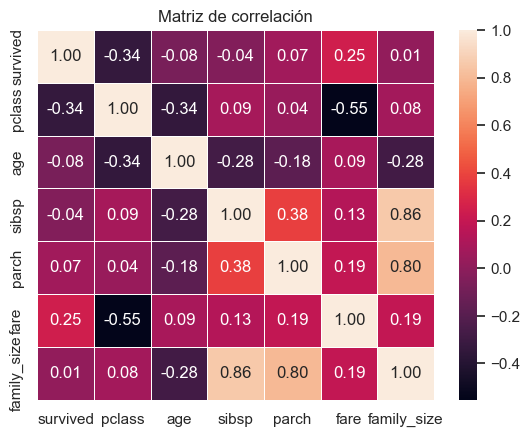

Outliers en age: 32 (límites: 0.38, 57.38)
Guardado: figures\plot_box_age.png


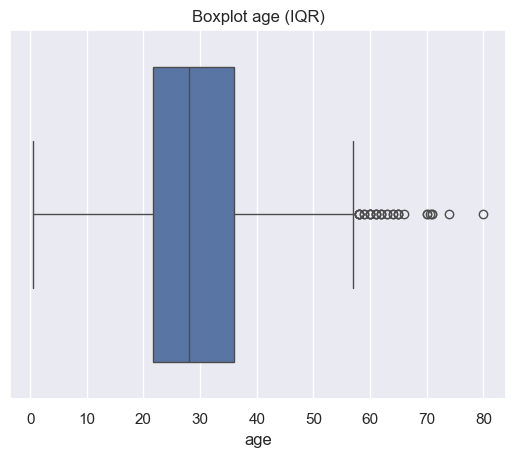

Outliers en fare: 97 (límites: -31.44, 73.86)
Guardado: figures\plot_box_fare.png


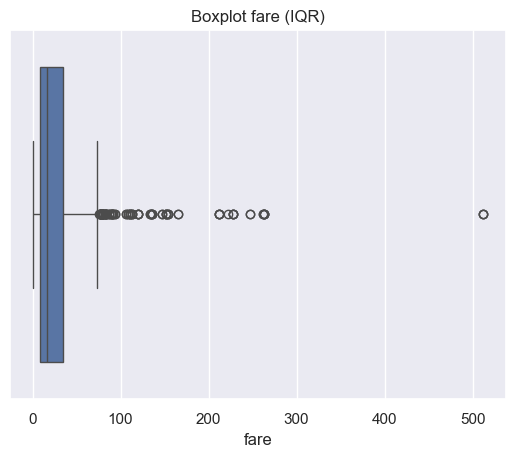

In [7]:
# Celda 7 — Correlación y outliers (IQR)
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr(numeric_only=True)

plt.figure()
ax = sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5)
ax.set_title("Matriz de correlación")
savefig("plot_corr_heatmap")
plt.show()

def outlier_mask_iqr(series, k=1.5):
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return (series < low) | (series > high), (low, high)

for col in ["age","fare"]:
    if col in df.columns:
        mask, (lo, hi) = outlier_mask_iqr(df[col])
        print(f"Outliers en {col}: {int(mask.sum())} (límites: {lo:.2f}, {hi:.2f})")
        plt.figure()
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot {col} (IQR)")
        savefig(f"plot_box_{col}")
        plt.show()


### plot_corr_heatmap.png
```bash
**Qué es:** Matriz de correlación entre variables numéricas
**Qué muestra:** Relaciones entre edad, tarifa, clase, familia, etc.
**Insight:** Identificar variables redundantes
```

### plot_box_age.png y plot_box_fare.png
```bash
**Qué son:** Boxplots para detección de outliers
**Qué muestran:** Ancianos y tarifas altas como valores atípicos
**Insight:** Outliers legítimos (no errores)
```

# Celda 8: Validación estadística. Tests de hipótesis:
T-test: Confirma que supervivientes pagaron más (p < 0.05) Chi-cuadrado: Confirma asociación sexo-supervivencia (p < 0.05)

In [8]:
# Celda 8 — Tests de hipótesis
if {"fare","survived"}.issubset(df.columns):
    g1 = df.loc[df["survived"]==1, "fare"].dropna()
    g0 = df.loc[df["survived"]==0, "fare"].dropna()
    t_stat, p_val = stats.ttest_ind(g1, g0, equal_var=False)
    print(f"T-test fare | survived: t={t_stat:.3f}, p={p_val:.3e}")

if {"sex","survived"}.issubset(df.columns):
    cont = pd.crosstab(df["sex"], df["survived"])
    chi2, p, dof, _ = stats.chi2_contingency(cont)
    print("Chi-cuadrado sex ~ survived:")
    display(cont)
    print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3e}")
    # (opcional) guardar tabla de contingencia:
    save_table_image(cont, "tbl_contingency_sex_survived", title="Tabla contingencia sex~survived", round_ndigits=None)



T-test fare | survived: t=6.378, p=4.642e-10
Chi-cuadrado sex ~ survived:


survived,0,1
sex,,
female,76,216
male,382,106


chi2=203.614, dof=1, p=3.397e-46
Tabla guardada: figures\tbl_contingency_sex_survived.png


# FASE 5 Conclusiones y preparación:

## Celda 9 — exportar CSVs limpios

## Resumen y Conclusiones

El **análisis exploratorio de datos (EDA)** proporciona una comprensión profunda de las características de los datos y sus relaciones. Al final de este proceso, es fundamental sintetizar los hallazgos, identificar problemas y formular recomendaciones para los siguientes pasos en el análisis o en la construcción de modelos. 

**Temas cubiertos:**

**- Hallazgos Principales**

El objetivo del resumen es destacar los hallazgos más importantes y relevantes que surgieron del EDA. Estos hallazgos pueden incluir:

    **•	Distribuciones de las variables:** Cómo se distribuyen los datos (normal, sesgada, etc.).
    **•	Relaciones entre variables:** Identificación de correlaciones significativas o relaciones entre variables predictoras y la variable objetivo.
    **•	Datos atípicos y valores faltantes:** Determinar si existen valores atípicos o si falta información importante en las variables.
    **•	Características importantes:** Variables que tienen un impacto significativo en la variable objetivo, basadas en análisis estadísticos o técnicas de machine learning.

Un buen resumen debe proporcionar una visión clara de las características del conjunto de datos y cómo estas características podrían influir en el modelo.


**- Problemas Identificados**

Durante el EDA, es común encontrar problemas que podrían afectar la calidad del análisis o la precisión de los modelos. Algunos de los problemas más comunes incluyen:

    **•	Valores faltantes:** Grandes cantidades de datos ausentes en algunas columnas que podrían afectar el rendimiento del modelo.
    **•	Outliers:** Valores atípicos que pueden distorsionar las distribuciones y afectar la exactitud de los modelos predictivos.
    **•	Multicolinealidad:** Variables altamente correlacionadas entre sí, lo que puede causar problemas en modelos de regresión lineales o algoritmos sensibles a la multicolinealidad.
    **•	Distribuciones sesgadas:** Variables que no siguen una distribución normal y que pueden requerir transformaciones para mejorar el análisis.

Identificar estos problemas es crucial para decidir cómo tratarlos antes de avanzar al modelado.


**- Recomendaciones para Pasos Siguientes**

Basado en los hallazgos y problemas identificados, se deben proponer recomendaciones claras para el análisis posterior. Algunas recomendaciones comunes incluyen:

    **•	Manejo de valores faltantes:** Imputar valores faltantes o eliminar registros, dependiendo de la cantidad y la importancia de los datos faltantes.
    **•	Tratamiento de outliers:** Eliminar, transformar o manejar los outliers, dependiendo de su impacto en el análisis.
    **•	Selección de características:** Elegir las características más relevantes basadas en su importancia para la variable objetivo, utilizando técnicas como la selección automática de características o la eliminación manual de aquellas con baja correlación.
    **•	Transformaciones de datos:** Normalizar o estandarizar variables cuando sea necesario para mejorar el rendimiento de ciertos modelos.
    **•	Pruebas de validación:** Realizar validaciones cruzadas o pruebas adicionales para verificar la calidad del modelo antes de la implementación.



In [9]:
# Celda 9 — Exportar CSVs limpios
df_encoded = pd.get_dummies(df, drop_first=True)
df.to_csv("titanic_clean.csv", index=False)
df_encoded.to_csv("titanic_encoded.csv", index=False)
print("Guardados: titanic_clean.csv, titanic_encoded.csv")

Guardados: titanic_clean.csv, titanic_encoded.csv


📋 ARCHIVOS CSV (2 datasets procesados):

```bash
# 1. titanic_clean.csv

Qué es: Datos originales pero limpios
Contiene: Valores imputados, sin duplicados, tipos corregidos
Uso: Para análisis posterior manteniendo interpretabilidad


# 2. titanic_encoded.csv

Qué es: Datos codificados para Machine Learning
Contiene: Variables categóricas convertidas a números (one-hot encoding)
Uso: Listo para entrenar algoritmos de IA
```

🎯 INSIGHTS PRINCIPALES DESCUBIERTOS:

**Factor género es CRÍTICO** - Diferencia dramática hombre vs mujer
**Clase social importa** - Tarifas altas = mayor supervivencia
**Protocolo marítimo cumplido** - "Mujeres y niños primero"
**Variables engineered útiles** - family_size puede mejorar predicciones
**Datos de calidad** - Pocos problemas tras limpieza

Este script es un ejemplo perfecto de EDA profesional aplicando toda la teoría que estudiamos. 